# Model Analysis

In [1]:
import tensorflow as tf
import sys
sys.path.append("../")
from federated.data.mitbih_data_preprocessing import load_data
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import itertools
%matplotlib inline

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
"""
Function that evaluates the model.
Prints accuracy and loss value
"""
def evaluation(X, y, model):
    scores = model.evaluate(X, y, verbose=0)
    print(f"Accuracy: {scores[1]*100}%, Loss: {scores[0]}")



In [4]:
"""
Function that creates confusion matrix based upon the dataset and the model
Displays the confusion matrix for the model.
"""

def make_confusion_matrix(X,y, model):
    y_pred = model.predict(X)
    y_test = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    cnf_matrix = confusion_matrix(y_test, y_pred)

    labels = ["N", "S", "V", " F", "U"]

    plt.figure(figsize=(15,15))
    cnf_matrix =  cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45)
    plt.yticks(ticks, labels)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j], '.2f'), horizontalalignment="center",
                    color="white" if cnf_matrix[i, j] > cnf_matrix.max()/2 else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


    plt.show()

In [5]:
"""
Function that loads model and dataset for analysis
Returns x_test, y_test and model
"""
def load(name):
    model = tf.keras.models.load_model("../history/logdir/" + name)
    X_test, y_test = load_data(data_analysis=True)

    X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
    # X_test.shape
    evaluation(X_test, y_test, model)
    
    return X_test, y_test, model

# Model analysis for centralized learning

## Loading model and test dataset for centralized

In [12]:
X_test, y_test, model_centralized = load("centralized_sgd_normalized_v1")

## Evaluating model for centralized

In [14]:
evaluation(X_test,y_test,model_centralized)

Accuracy: 94.7515070438385%, Loss: 0.19212722778320312


## Confusion Matrix

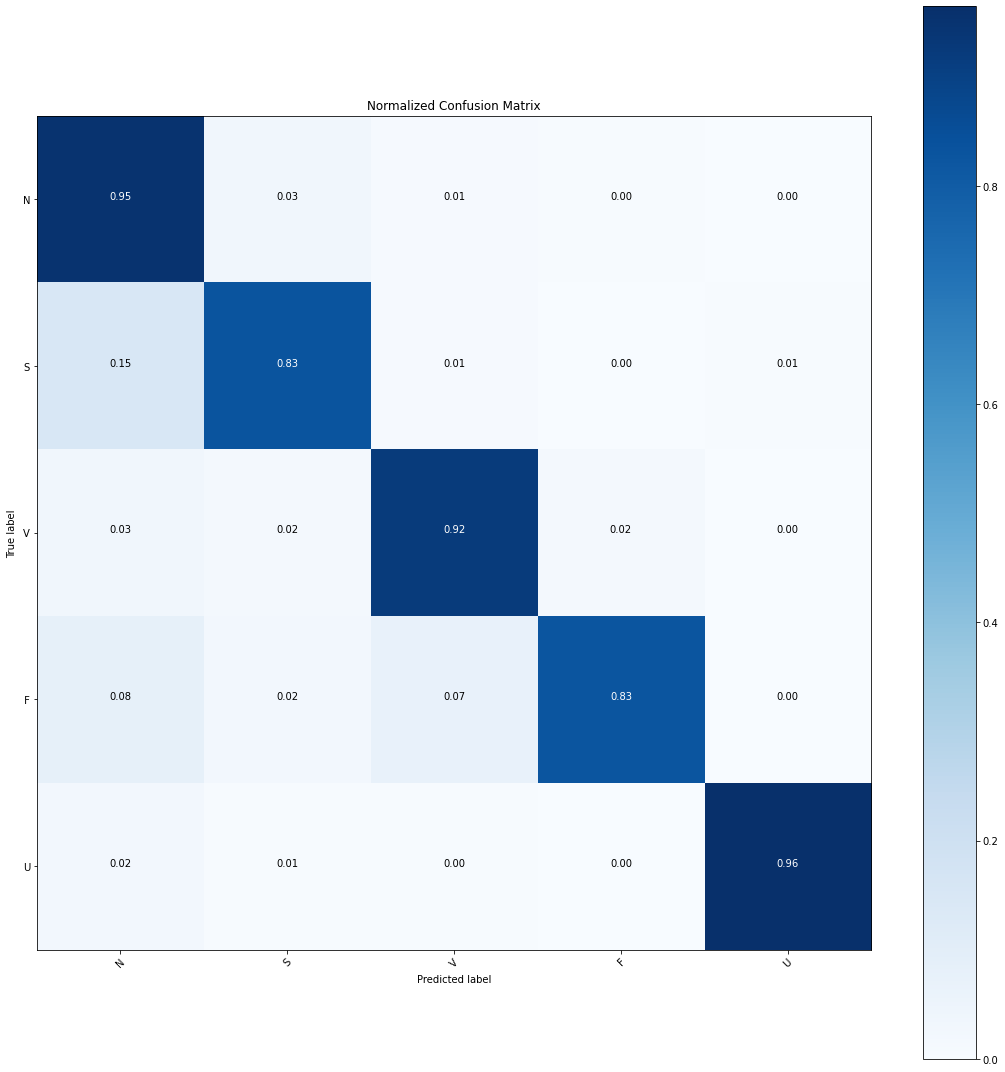

In [16]:
make_confusion_matrix(X_test, y_test, model_centralized)

# Model analysis for SGD FL

## Loading dataset and model for federated learning

In [18]:
X_test, y_test, model_fed = load("FedSGD_normalized_nonIID_v0")

## Evaluating model for federated learning

In [20]:
evaluation(X_test, y_test, model_fed)

Accuracy: 65.04202485084534%, Loss: 1.0060189962387085


## Confusion Matrix for federated learning

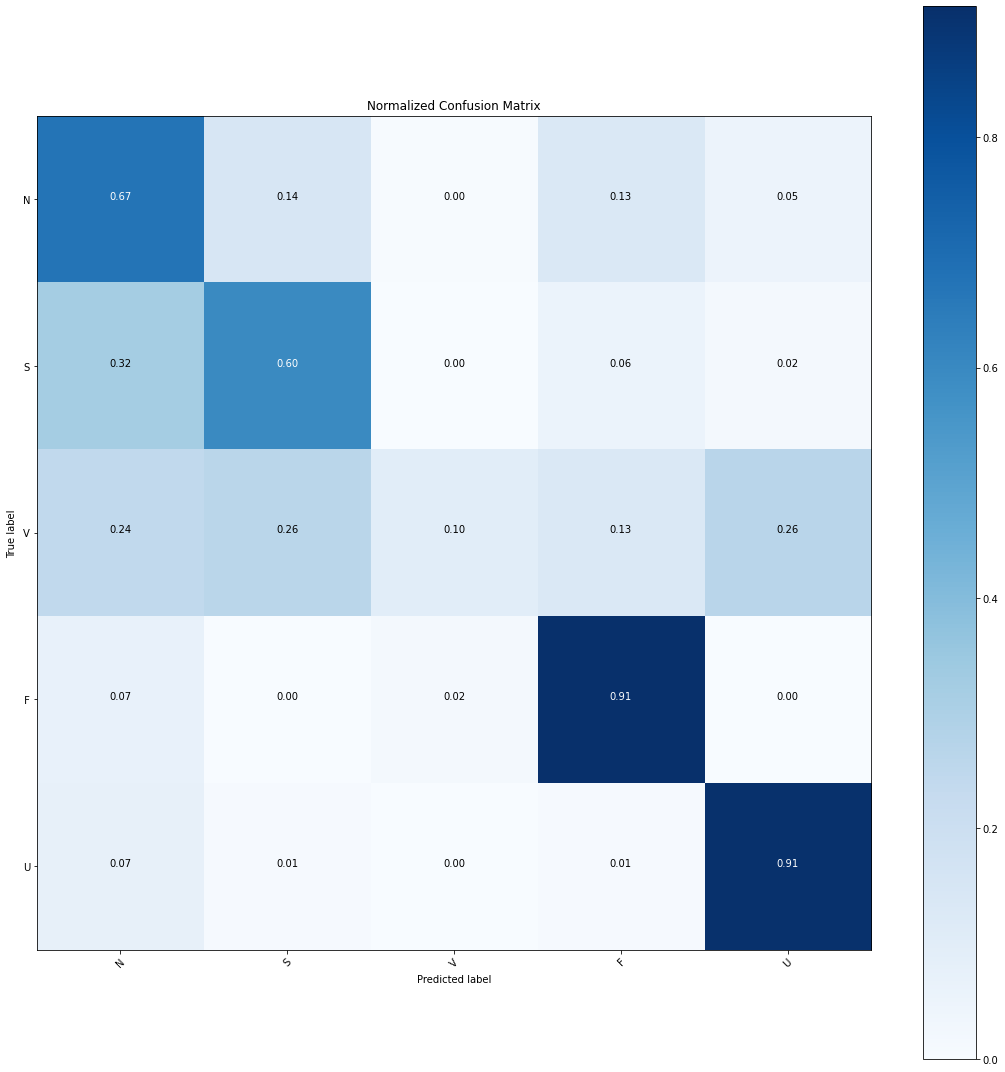

In [22]:
make_confusion_matrix(X_test, y_test, model_fed)

# Model analysis for FedAvg

In [24]:
 X_test, y_test, model_fed = load("FedAvg_normalized_nonIID_v0")

In [26]:
evaluation(X_test, y_test, model_fed)

Accuracy: 93.64151358604431%, Loss: 0.273680716753006


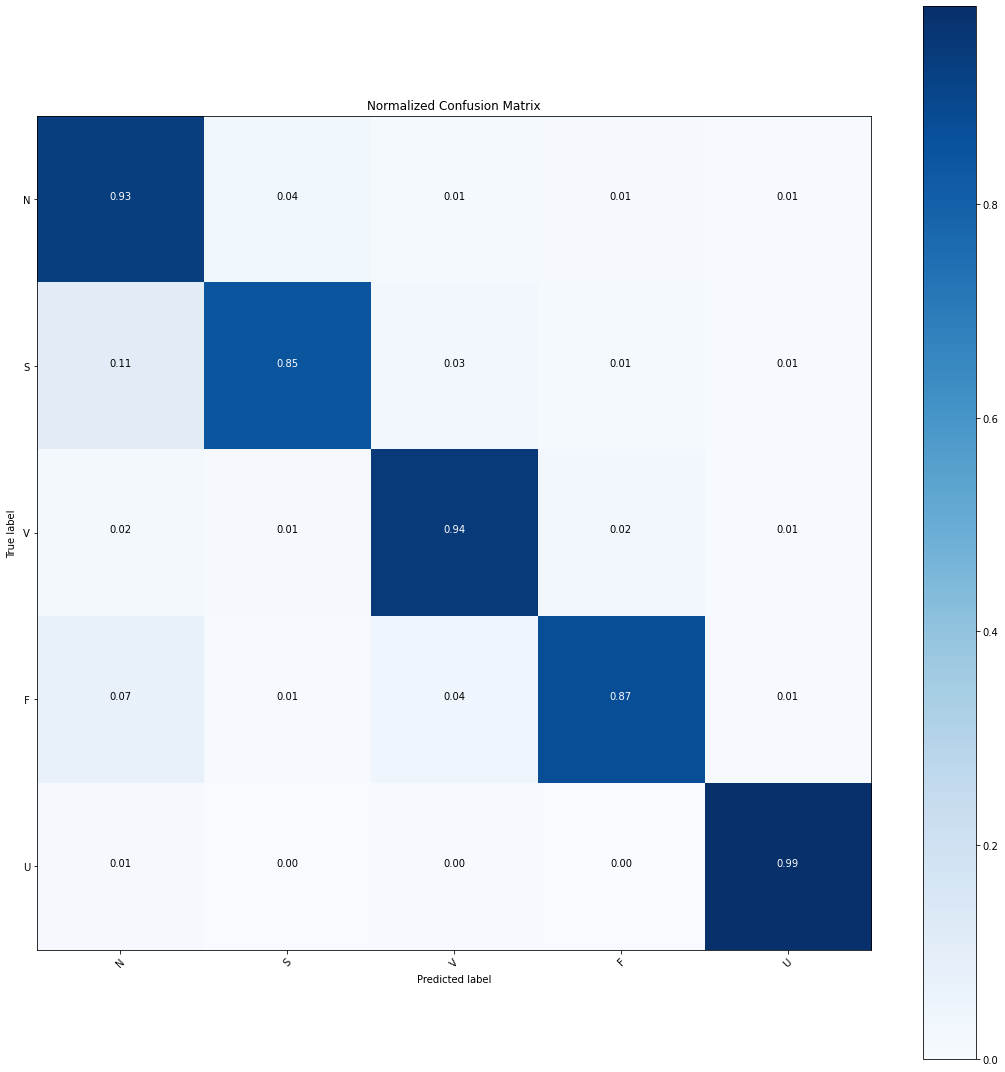

In [28]:
make_confusion_matrix(X_test, y_test, model_fed)

# Model analysis for robust aggregation FL

In [30]:
 X_test, y_test, model_fed = load("robust_aggregation_normalized_v0")

In [32]:
evaluation(X_test, y_test, model_fed)

Accuracy: 93.63694787025452%, Loss: 0.24541081488132477


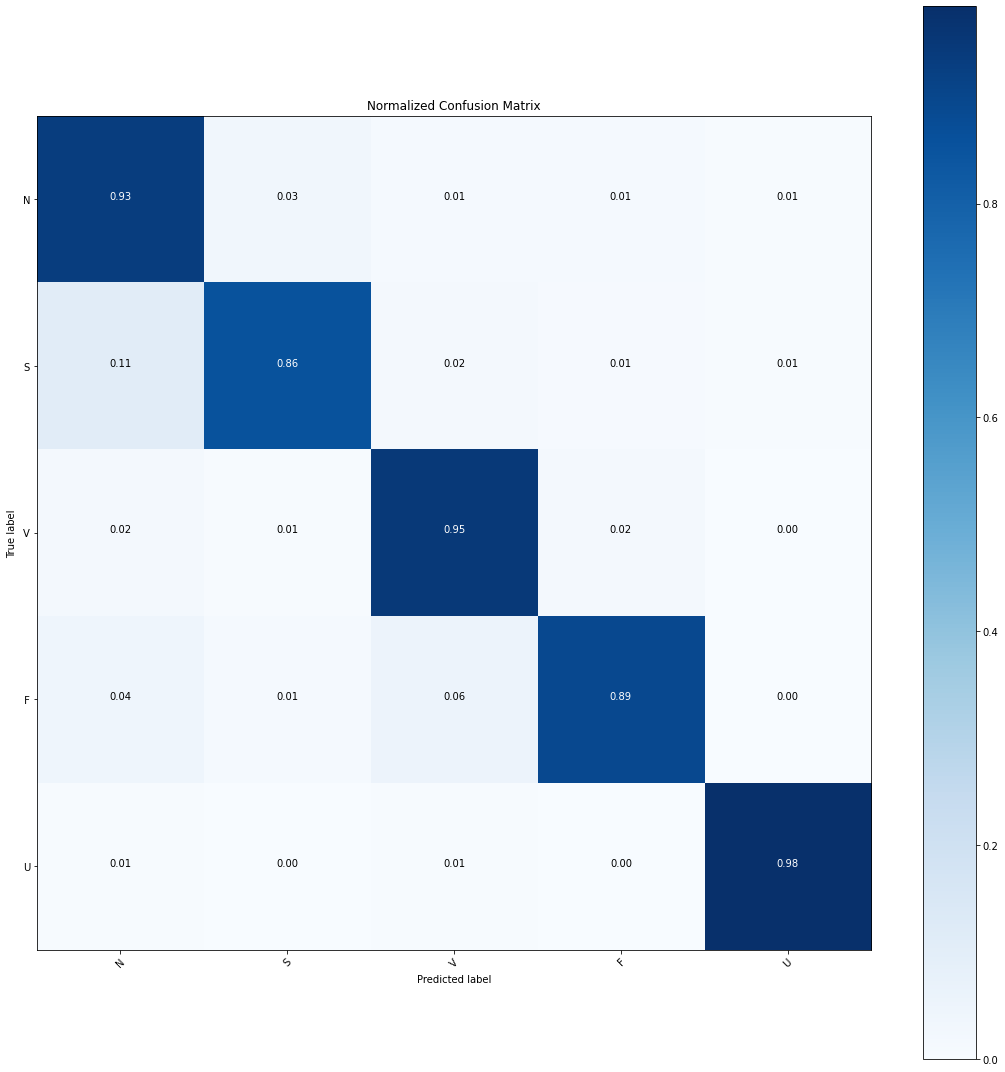

In [34]:
make_confusion_matrix(X_test, y_test, model_fed)

## FedavgCNN vs centralizedCNN for 100 UK

In [36]:
 X_test, y_test, model_fed = load("fedavgCNN/100_cnn_fed_v0")

In [38]:
evaluation(X_test, y_test, model_fed)

Accuracy: 94.82002854347229%, Loss: 0.3196646273136139


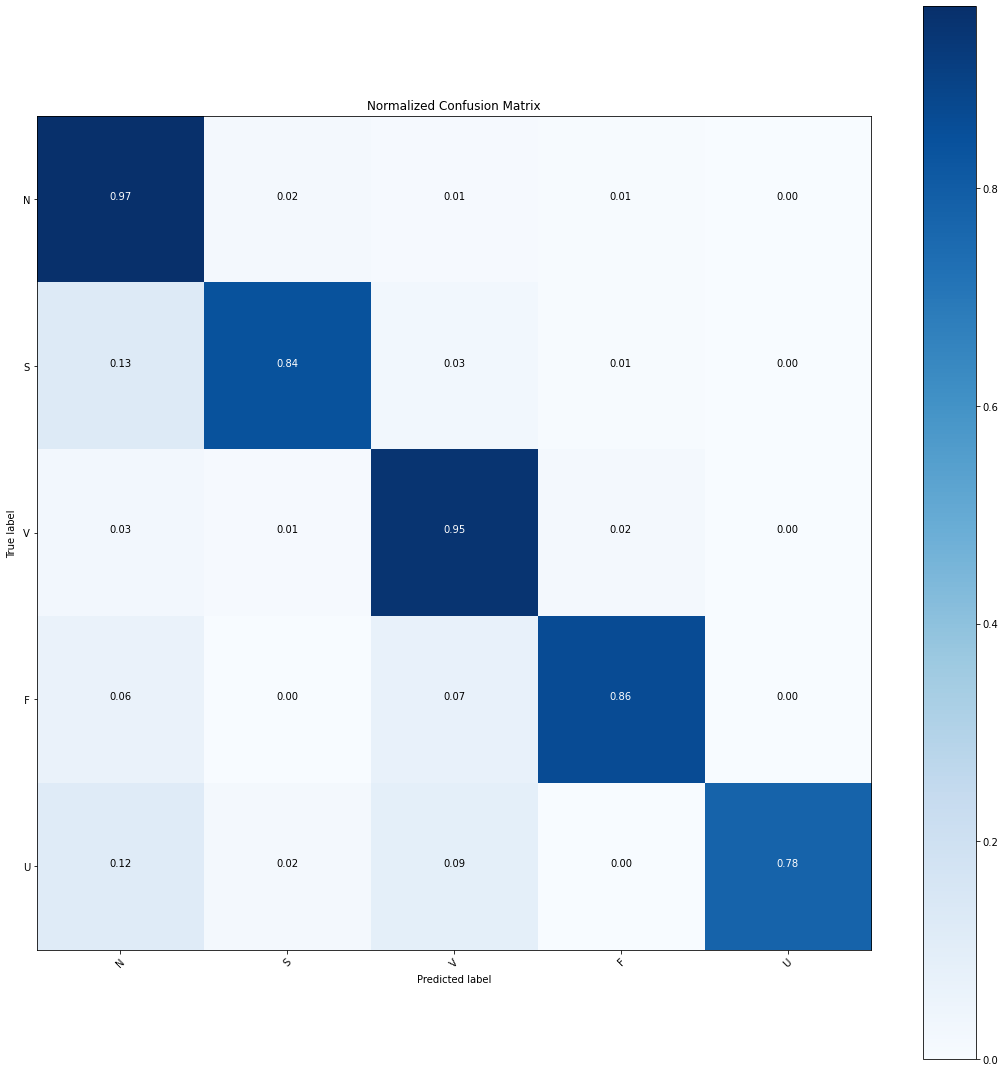

In [40]:
make_confusion_matrix(X_test, y_test, model_fed)

In [42]:
 X_test, y_test, model_fed = load("centralizedCNN/100_cnn_centralized_v0")

In [44]:
evaluation(X_test, y_test, model_fed)

Accuracy: 95.12150287628174%, Loss: 0.27906689047813416


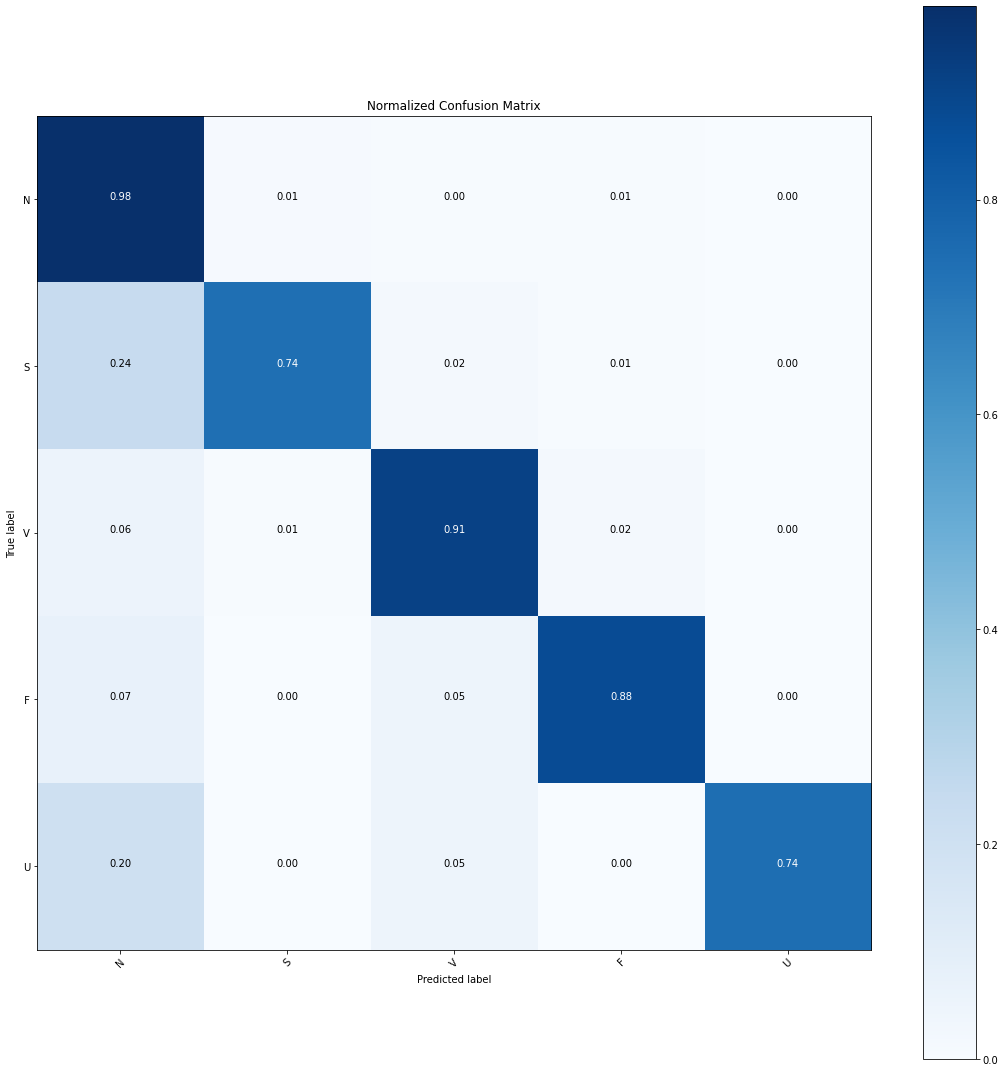

In [46]:
make_confusion_matrix(X_test, y_test, model_fed)

## FedavgCNN vs centralizedCNN for 10 UK

In [48]:
 X_test, y_test, model_fed = load("fedavgCNN/10_cnn_fed_v0")

In [50]:
evaluation(X_test, y_test, model_fed)

Accuracy: 92.29855537414551%, Loss: 0.5360586047172546


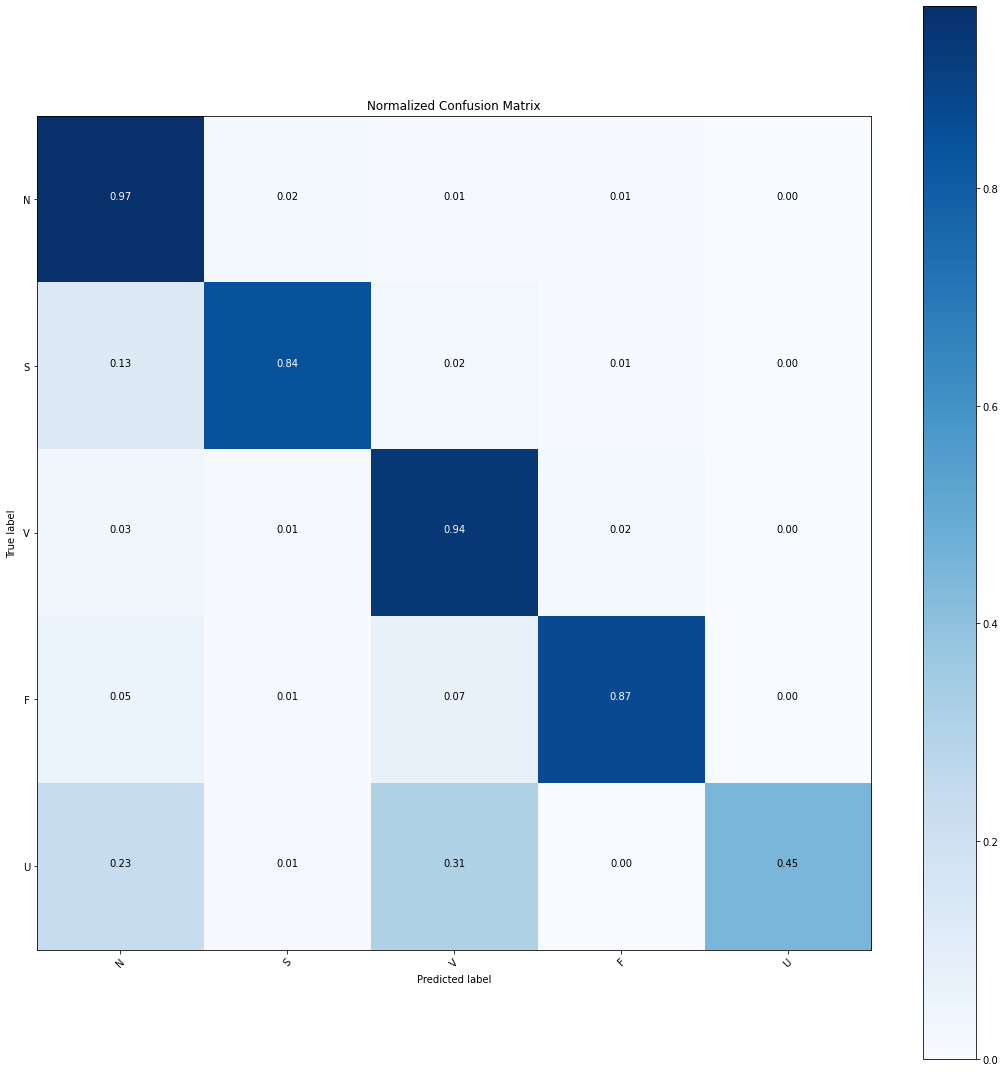

In [52]:
make_confusion_matrix(X_test, y_test, model_fed)

In [54]:
 X_test, y_test, model_fed = load("centralizedCNN/10_cnn_centralized_v0")

In [56]:
evaluation(X_test, y_test, model_fed)

Accuracy: 92.89695024490356%, Loss: 0.5105098485946655


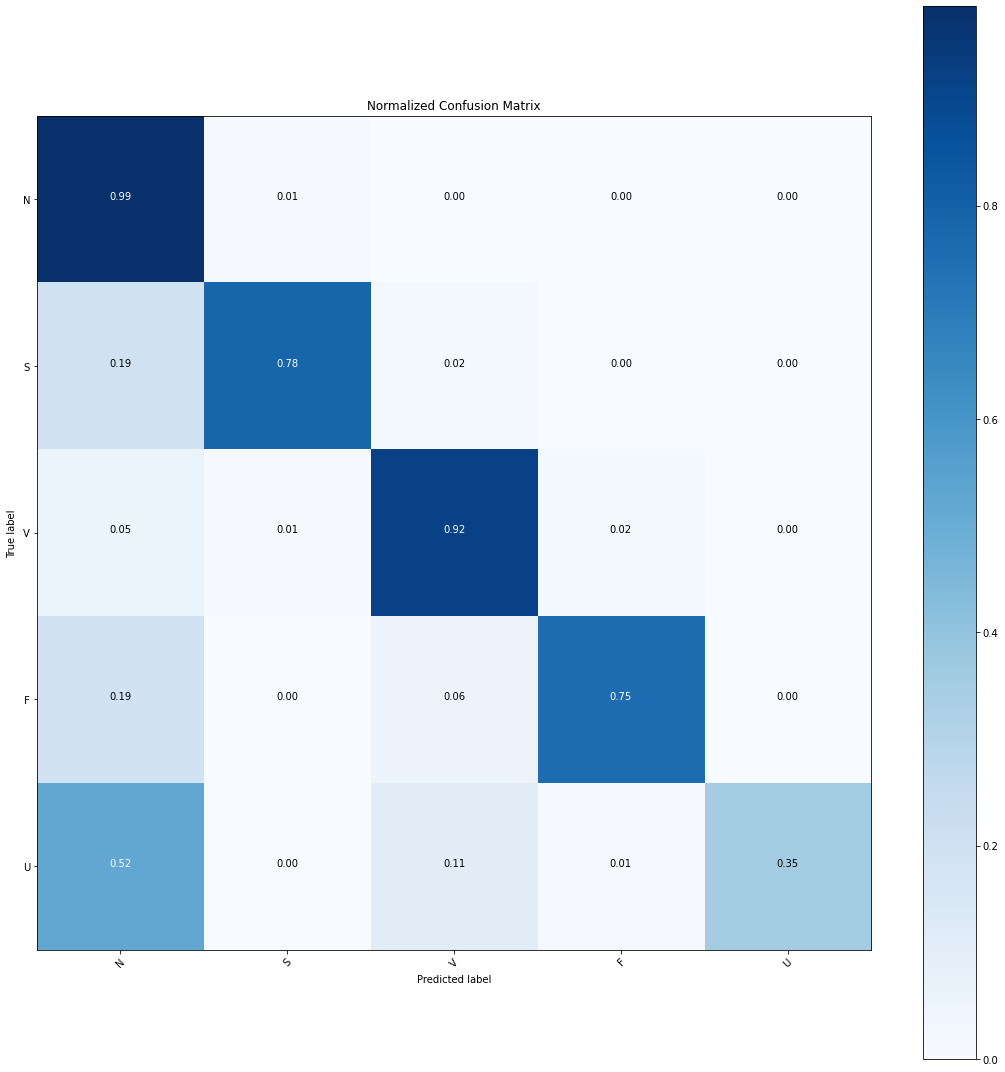

In [58]:
make_confusion_matrix(X_test, y_test, model_fed)

## FedavgCNN vs centralizedCNN for 1 UK

In [60]:
 X_test, y_test, model_fed = load("fedavgCNN/1_cnn_fed_v0")

In [62]:
evaluation(X_test, y_test, model_fed)

Accuracy: 88.85437846183777%, Loss: 2.087238311767578


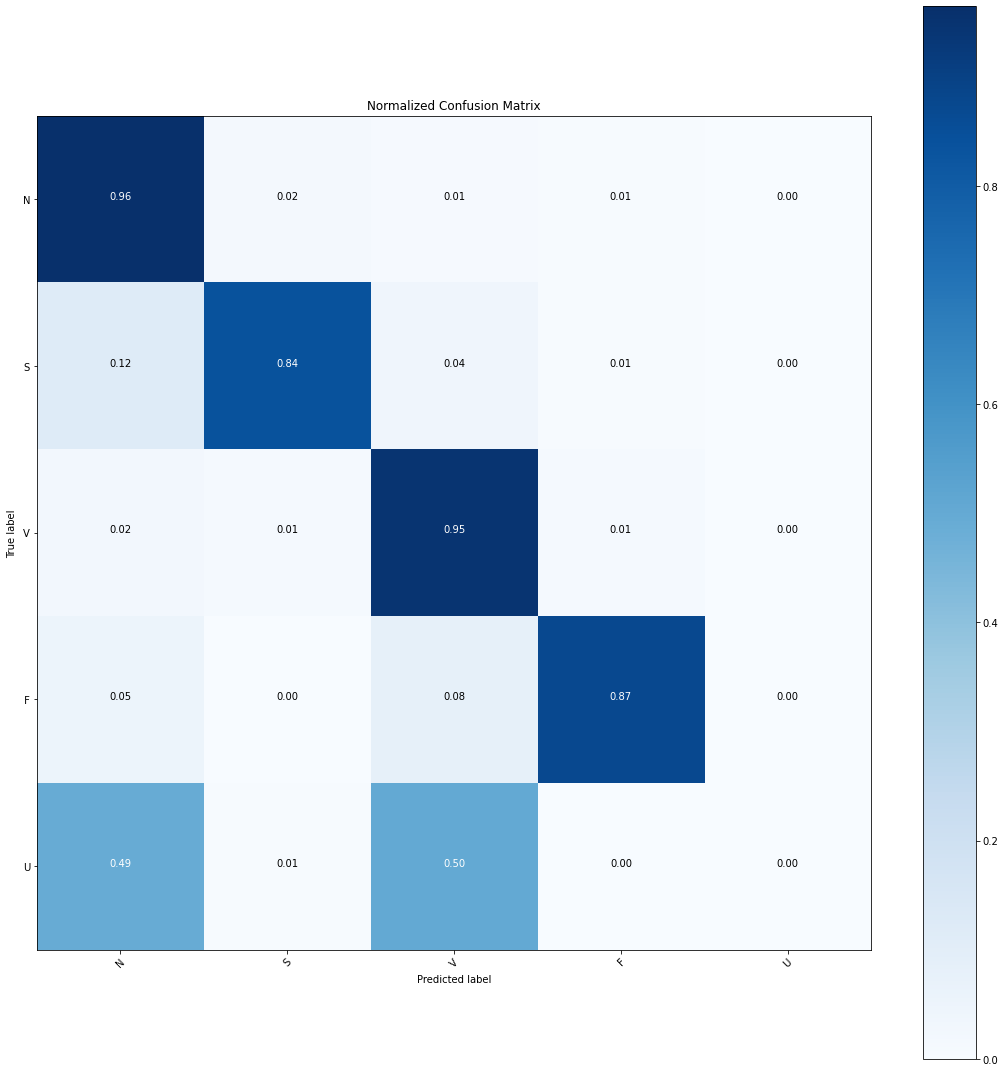

In [64]:
make_confusion_matrix(X_test, y_test, model_fed)

In [66]:
 X_test, y_test, model_fed = load("centralizedCNN/1_cnn_centralized_v0")

In [68]:
evaluation(X_test, y_test, model_fed)

Accuracy: 87.90425658226013%, Loss: 1.865127444267273


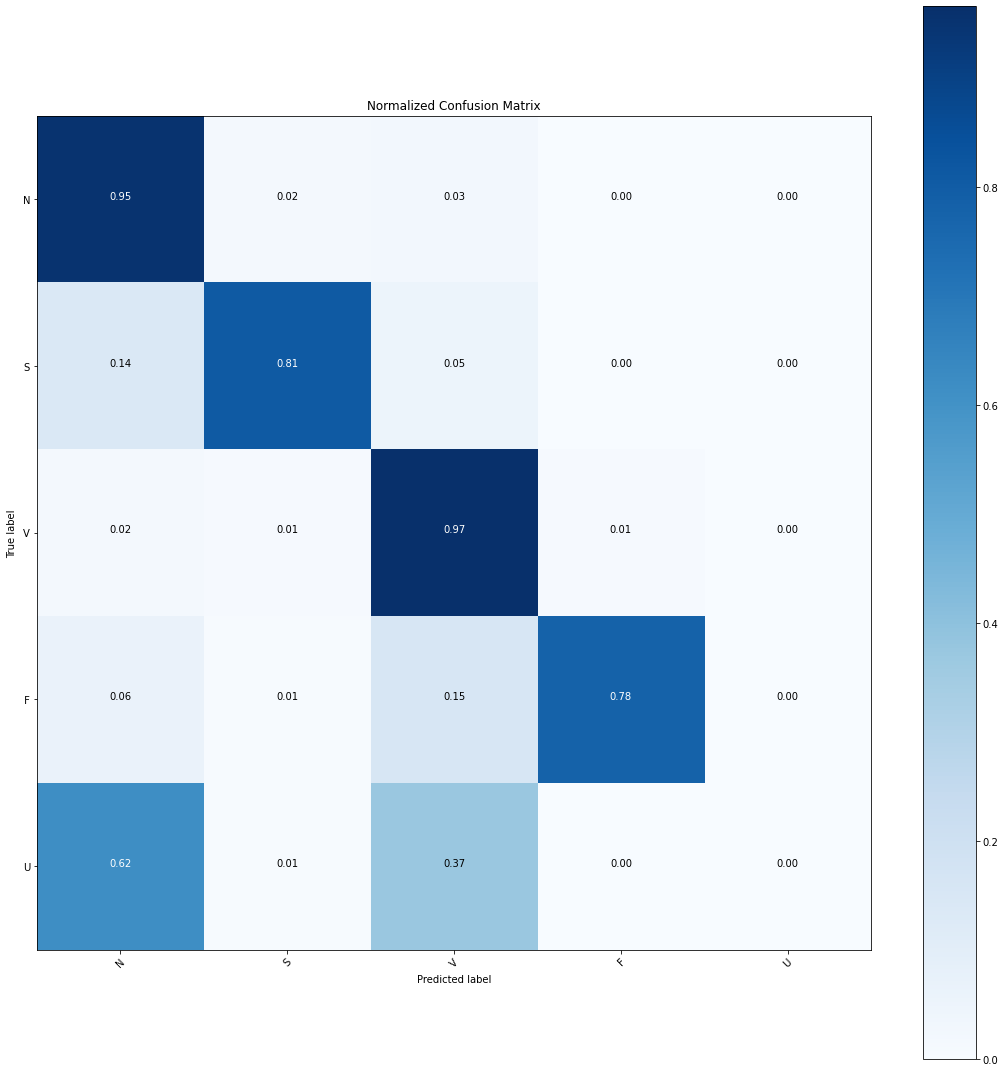

In [70]:
make_confusion_matrix(X_test, y_test, model_fed)

## FedavgDense vs centralizedDense for 100 uk

In [72]:
 X_test, y_test, model_fed = load("fedavgDense/100_dense_fed_v0")

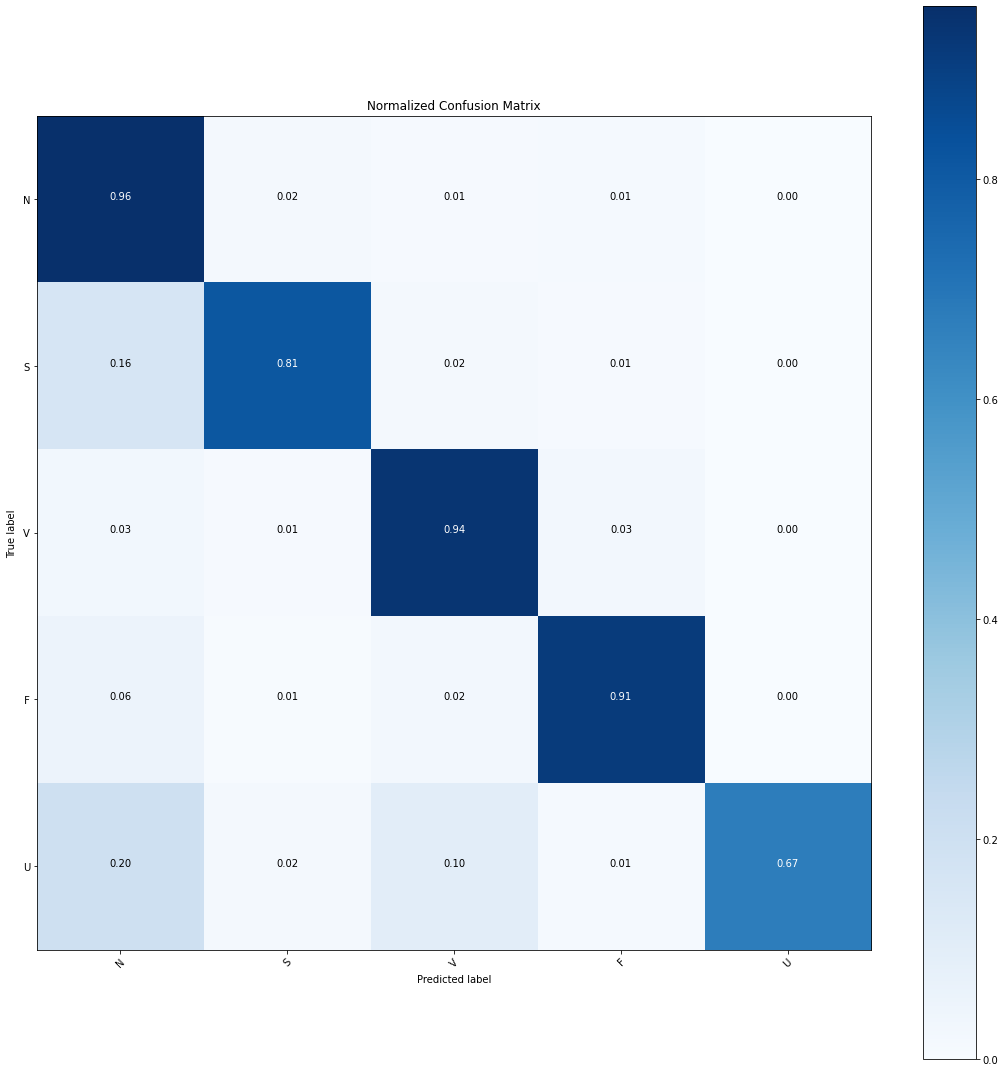

In [76]:
make_confusion_matrix(X_test, y_test, model_fed)

In [78]:
 X_test, y_test, model_fed = load("centralizedDense/100_dense_centralized_v0")

In [80]:
evaluation(X_test, y_test, model_fed)

Accuracy: 82.61008858680725%, Loss: 0.5898311138153076


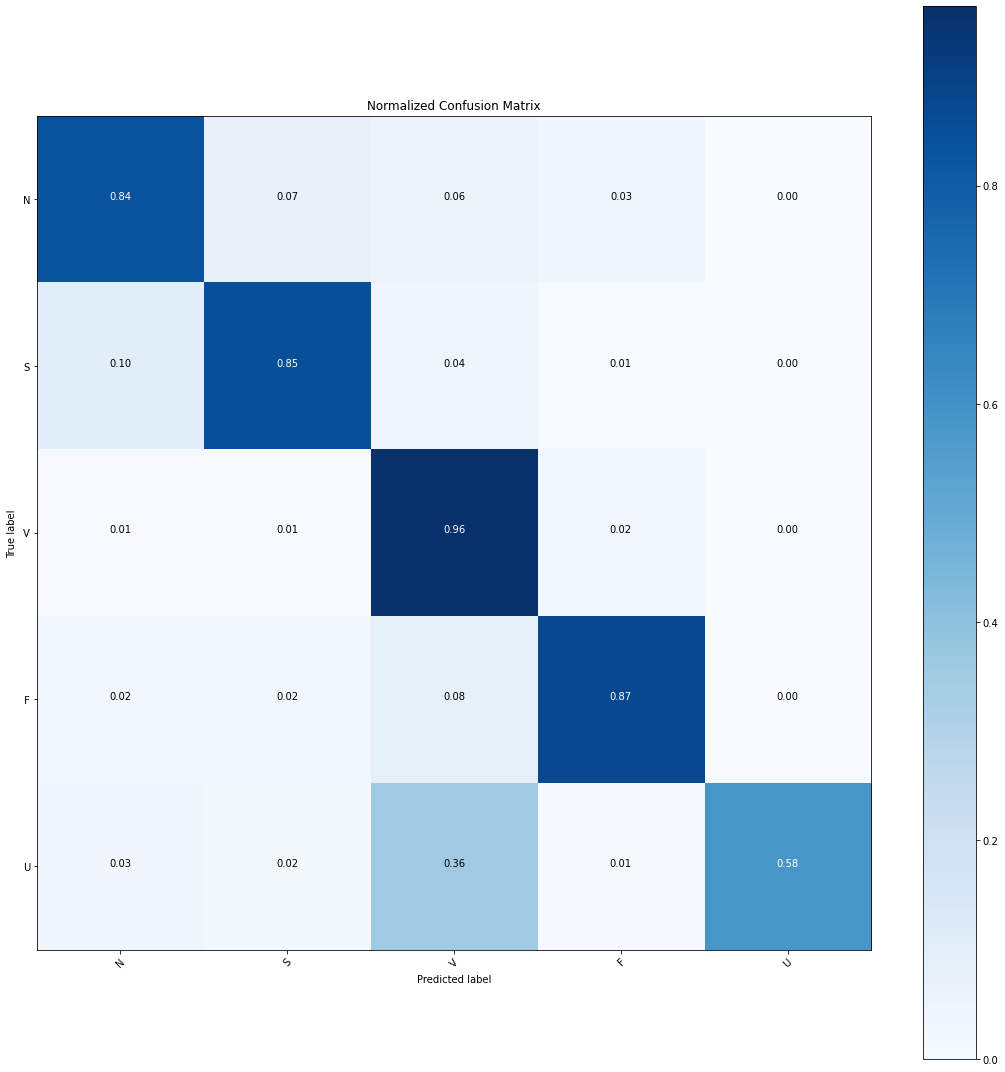

In [82]:
make_confusion_matrix(X_test, y_test, model_fed)

## FedavgDense vs centralizedDense for 10 uk

In [84]:
 X_test, y_test, model_fed = load("fedavgDense/10_dense_fed_v0")

In [86]:
evaluation(X_test, y_test, model_fed)

Accuracy: 88.41586112976074%, Loss: 0.7375065684318542


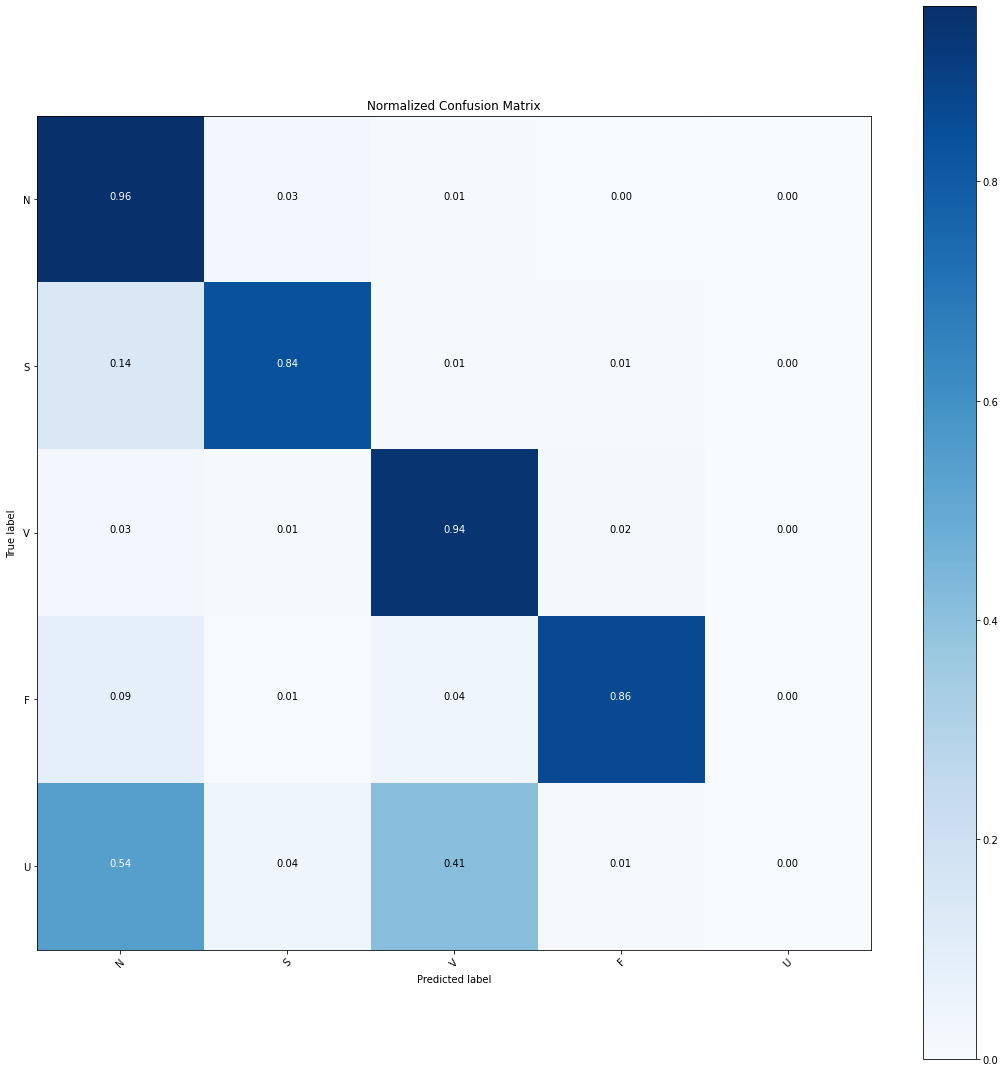

In [88]:
make_confusion_matrix(X_test, y_test, model_fed)

In [90]:
 X_test, y_test, model_fed = load("centralizedDense/10_dense_centralized_v0")

In [92]:
evaluation(X_test, y_test, model_fed)

Accuracy: 88.99598121643066%, Loss: 0.6971701383590698


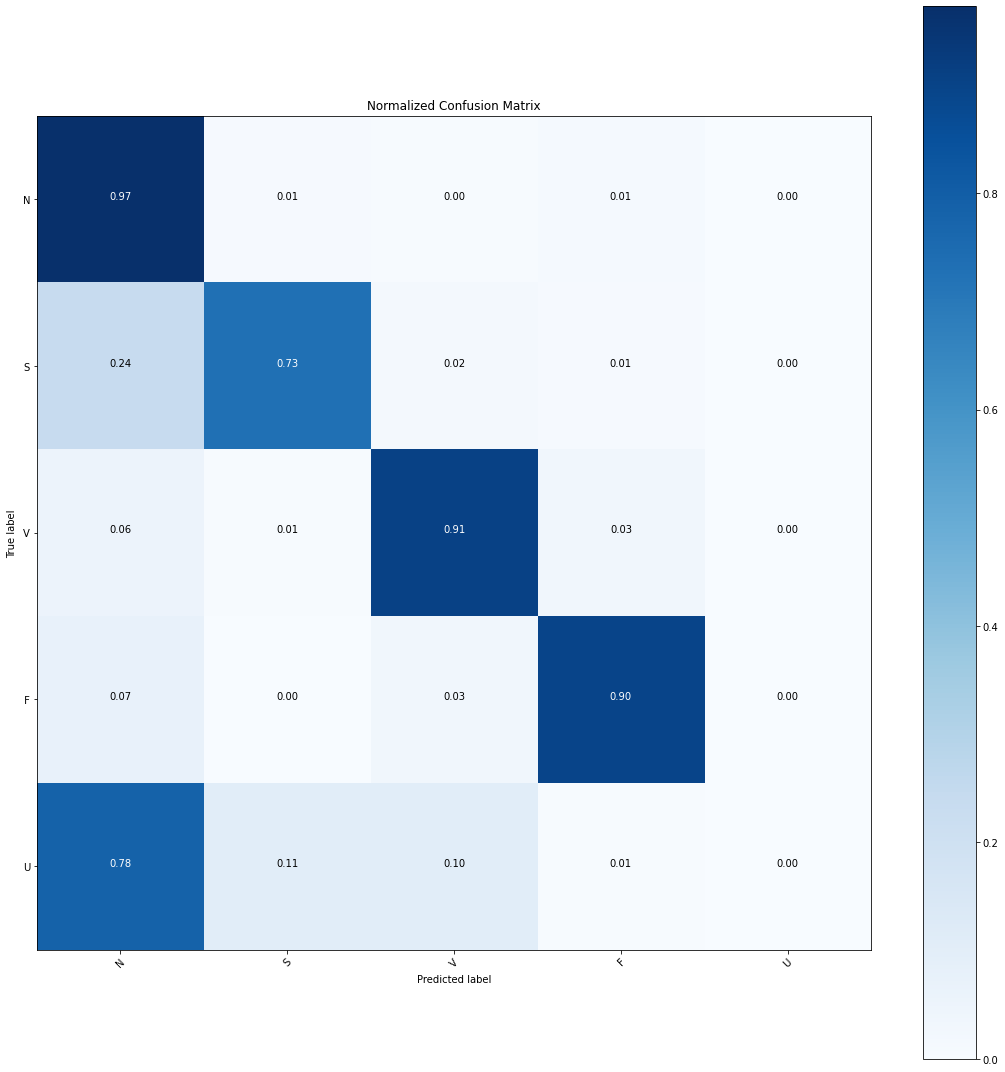

In [94]:
make_confusion_matrix(X_test, y_test, model_fed)

## FedavgDense vs centralizedDense for 1 uk

In [96]:
 X_test, y_test, model_fed = load("fedavgDense/1_dense_fed_v0")

In [98]:
evaluation(X_test, y_test, model_fed)

Accuracy: 86.98611259460449%, Loss: 1.66640305519104


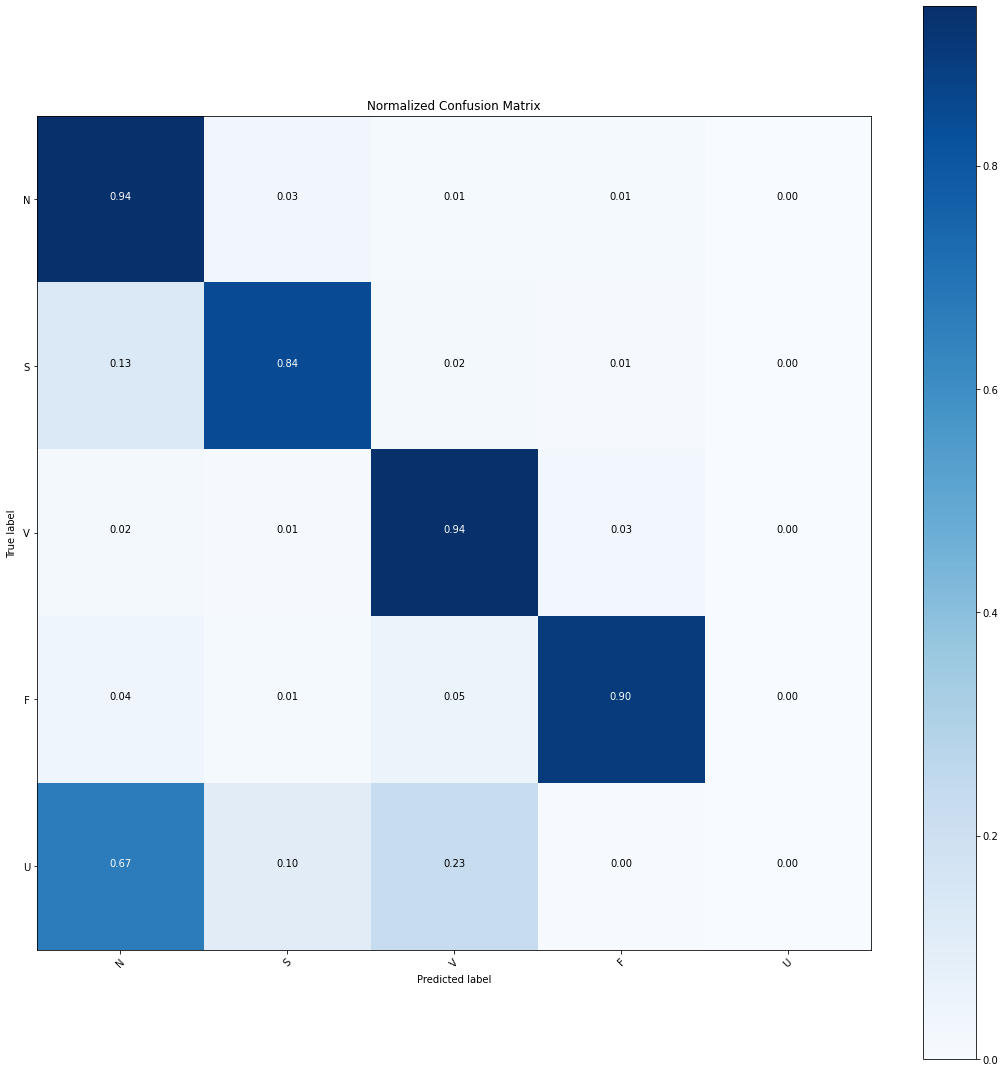

In [100]:
make_confusion_matrix(X_test, y_test, model_fed)

In [102]:
X_test, y_test, model_fed = load("centralizedDense/1_dense_centralized_v0")

In [104]:
evaluation(X_test, y_test, model_fed)

Accuracy: 85.57007312774658%, Loss: 1.8734495639801025


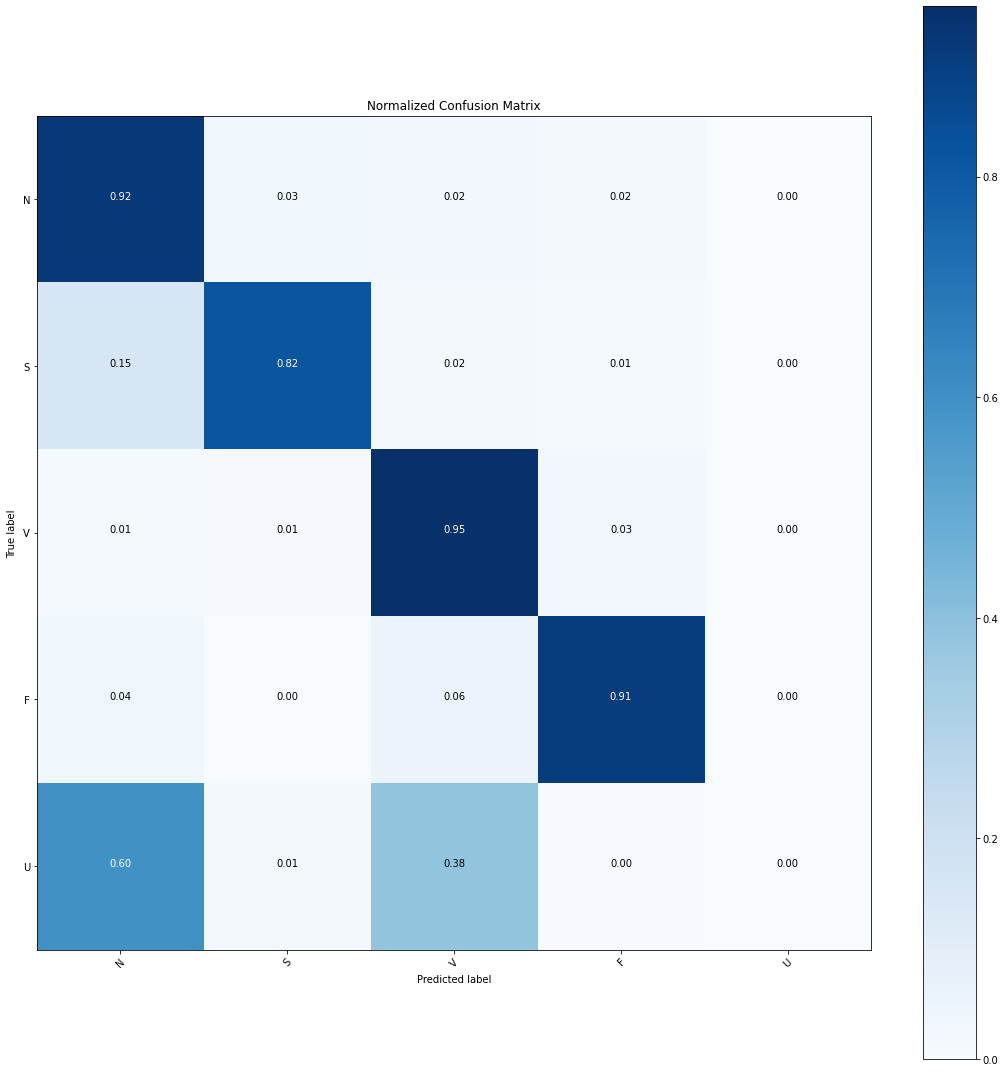

In [106]:
make_confusion_matrix(X_test, y_test, model_fed)

## Differential Privacy (noise_multiplier=0.01, number_of_clients_per_round=10, clipping_norm=0.5) 

In [30]:
 X_test, y_test, model_fed = load("fedavgCNN/100_cnn_fed_v0")

Accuracy: 94.82002854347229%, Loss: 0.3196646273136139


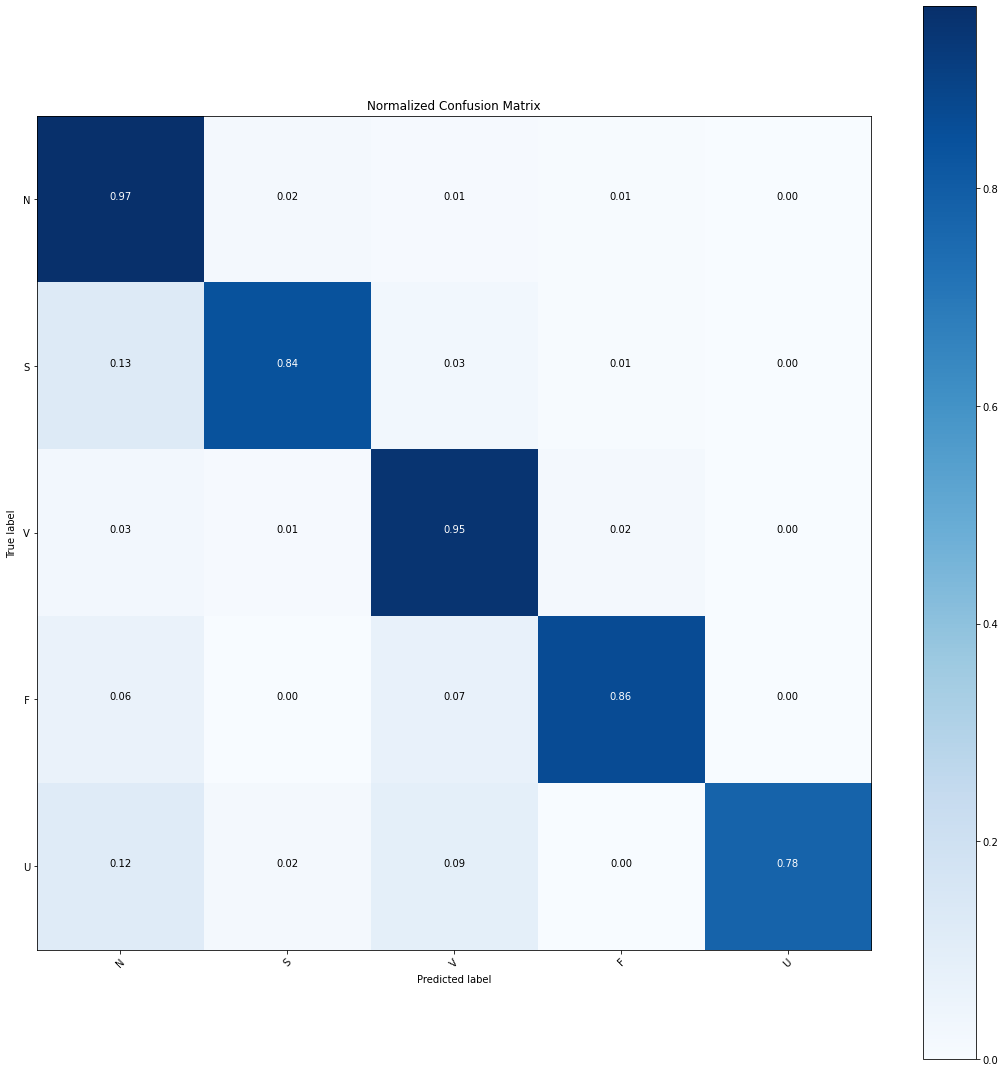

In [31]:
make_confusion_matrix(X_test, y_test, model_fed)

In [32]:
 X_test, y_test, model_fed = load("100_dp_fed_cnn_v0")

Accuracy: 77.63109803199768%, Loss: 1.0249556303024292


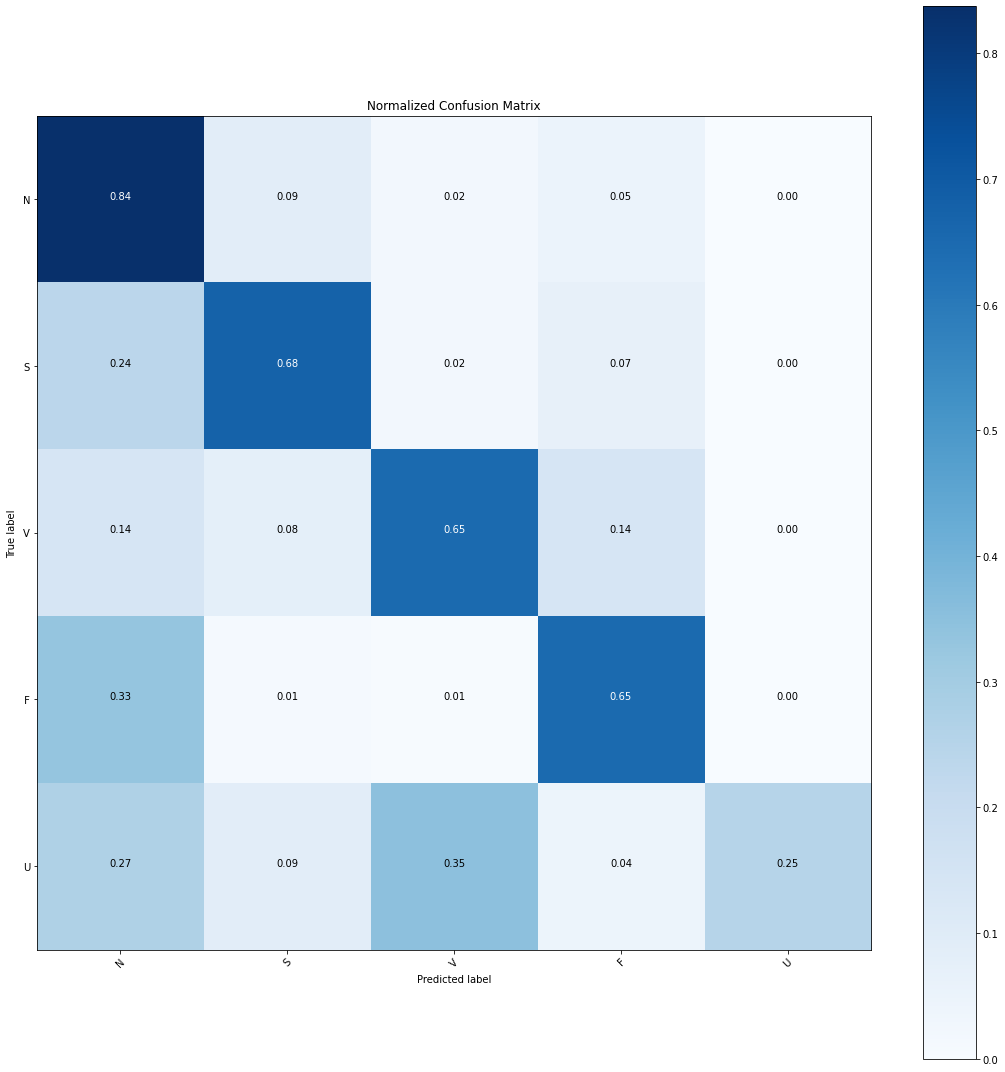

In [33]:
make_confusion_matrix(X_test, y_test, model_fed)